# Import Libraries

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from random import choice

In [14]:
import os
import pandas as pd
import csv
from google.colab import drive

# Data Loading

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
def process_directory(dir_path, dataframes_dict, target_key=None):
  for root, dirs, files in os.walk(dir_path):
    relative_path = os.path.relpath(root, dir_path)
    if relative_path != '.':
      if target_key:
        dataframes_dict[key][relative_path] = []
      else:
        dataframes_dict[relative_path] = []
    for file in files:
      df = pd.read_csv(os.path.join(root, file), header=None, sep="\t")
      df[1] = np.log1p(df[1].clip(lower=1e-5))
      scaler = MinMaxScaler()
      df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
      if target_key:
        dataframes_dict[key][relative_path].append(df)
      else:
        dataframes_dict[relative_path].append(df)
      dataframes_dict['scaler'] = scaler

In [25]:
directories = [('/content/drive/MyDrive/Database Raman/', None),
 ('/content/drive/MyDrive/Database Raman Campuran/Mix Lemak Babi-Sapi (S)/', 'Babi-Sapi'),
 ('/content/drive/MyDrive/Database Raman Campuran/Campuran/', None),
 ('/content/drive/MyDrive/Database Raman Campuran/Pengenceran/', 'Pengenceran')
]

dataframes = defaultdict(dict)
for dir, key in directories:
  process_directory(dir, dataframes, target_key=key)

In [26]:
list(dataframes.keys())

['Sapi',
 'scaler',
 'Kambing',
 'Bebek',
 'Babi',
 'Ayam',
 'Babi-Sapi',
 'Babi-Kambing-Sapi',
 'Babi-Kambing',
 'Babi-Kambing-Sapi-Bebek',
 'Babi-Kambing-Sapi-Bebek-Ayam',
 'Pengenceran']

# Data Augmentation

Using either (randomly):
- Vertical or horizontal Gaussian noise only
- Vertical or horizontal Gaussian noise and Savitzky-Golay filter
- Vertical Gaussian noise, horizontal Gaussian noise and Savitzky-Golay filter

In [27]:
def vertical_gaussian_noise(df_, mean_=0., std_=0.075):
  df_[1] += np.random.normal(mean_, std_)

def horizontal_gaussian_noise(df_, mean_=0., std_=0.005):
  df_[0] += np.random.normal(mean_, std_)

def savgol(df_, window_size=10, poly=np.random.randint(3, 5)):
  df_[1] = savgol_filter(df_[1], window_size, poly)

def augment(df_):
  df_new = df_.copy()
  method = choice(["single", "double", "all"])
  if method == "single":
    choice([vertical_gaussian_noise, horizontal_gaussian_noise])(df_new)
  elif method == "double":
    choice([vertical_gaussian_noise, horizontal_gaussian_noise])(df_new)
    savgol(df_new)
  else:
    vertical_gaussian_noise(df_new)
    horizontal_gaussian_noise(df_new)
    savgol(df_new)
  return df_new

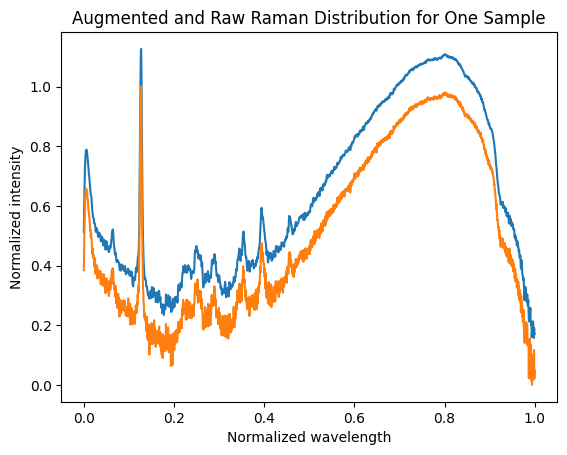

In [78]:
df_noise = augment(dataframes['Ayam'][0])
plt.title("Augmented and Raw Raman Distribution for One Sample")
plt.xlabel("Normalized wavelength")
plt.ylabel("Normalized intensity")
plt.plot(df_noise[0], df_noise[1])
plt.plot(dataframes['Ayam'][0][0], dataframes['Ayam'][0][1])
plt.show()

In [30]:
halal_keys = ['Ayam','Kambing','Sapi', 'Bebek']
augment_size = 30
df_halal = []
for key in halal_keys:
  for df in dataframes[key]:
    df_halal.append(df.values)
    for _ in range(augment_size):
      df_noise = augment(df)
      df_halal.append(df_noise.values)
df_halal = np.asarray(df_halal)
df_halal.shape[0]

1829

In [31]:
haram_keys = [('Babi'), ('Babi-Kambing'), ('Babi-Kambing-Sapi'),
              ('Babi-Kambing-Sapi-Bebek'), ('Babi-Kambing-Sapi-Bebek-Ayam'), ('Babi-Sapi'), ('Pengenceran')]
df_haram = []
augment_size = 5

for key in haram_keys:
  try:
    subkeys = list(dataframes[key].keys())
    for subkey in subkeys:
      if subkey in ['Konsentrasi 0%', 'Konsentrasi 100%']:
        continue
      for df in dataframes[key][subkey]:
        df_haram.append(df.values)
        for _ in range(augment_size):
          df_noise = augment(df)
          df_haram.append(df_noise.values)
  except AttributeError:
    for df in dataframes[key]:
      df_haram.append(df.values)
      for _ in range(augment_size):
        df_noise = augment(df)
        df_haram.append(df_noise.values)
df_haram = np.asarray(df_haram)
df_haram.shape[0]

1902

# Data Splitting

In [32]:
X = np.concatenate((df_halal, df_haram), axis=0)
y = np.array([0 for _ in range(df_halal.shape[0])] + [1 for _ in range(df_haram.shape[0])])

In [33]:
X.shape

(3731, 2048, 2)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.shape, X_test.shape

((2984, 2048, 2), (747, 2048, 2))

# Machine Learning Model

In [43]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Conv1D(100, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(tf.keras.layers.Conv1D(100, 5, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [44]:
model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=0,
                                            restore_best_weights=True)

In [46]:
history = model_cnn.fit(X_train, y_train,
                        epochs=1000,
                        verbose=0,
                        callbacks=[callback],
                        validation_data=(X_test, y_test))

# Model Evaluation

Training data loss value: 0.20498935878276825
Testing data loss value: 0.19256587326526642


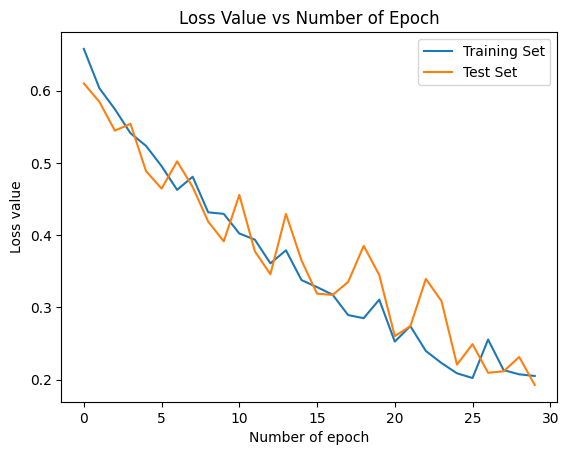

In [47]:
print("Training data loss value:", history.history['loss'][callback.best_epoch])
print("Testing data loss value:", history.history["val_loss"][callback.best_epoch])
plt.plot(history.history['loss'][:callback.best_epoch+1])
plt.plot(history.history['val_loss'][:callback.best_epoch+1])
plt.title('Loss Value vs Number of Epoch')
plt.ylabel('Loss value')
plt.xlabel('Number of epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

Training data accuracy: 91.25 %
Testing data accuracy: 94.24 %


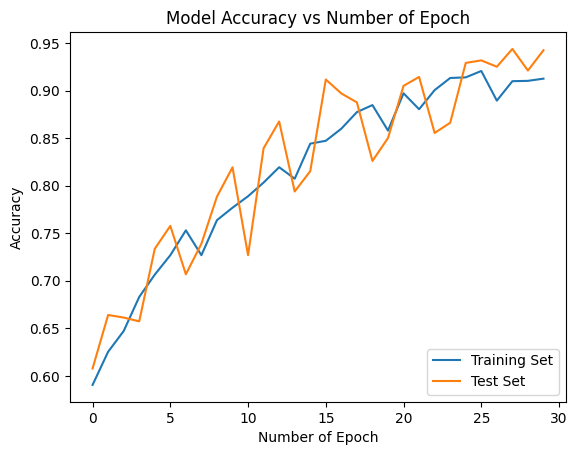

In [48]:
print("Training data accuracy:", round(history.history['acc'][callback.best_epoch]*100, 2), "%")
print("Testing data accuracy:", round(history.history['val_acc'][callback.best_epoch]*100, 2), "%")
plt.plot(history.history['acc'][:callback.best_epoch+1])
plt.plot(history.history['val_acc'][:callback.best_epoch+1])
plt.title('Model Accuracy vs Number of Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epoch')
plt.legend(['Training Set', 'Test Set'], loc='lower right')
plt.show()

# Train Data Results

In [52]:
y_train_pred = model_cnn.predict(X_train)
y_train_pred[y_train_pred <= 0.5] = 0. # halal
y_train_pred[y_train_pred > 0.5] = 1.  # haram
cm_train = confusion_matrix(y_train, y_train_pred)

94/94 [==============================] - 1s 6ms/step


In [53]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1452
           1       0.96      0.95      0.96      1532

    accuracy                           0.96      2984
   macro avg       0.96      0.96      0.96      2984
weighted avg       0.96      0.96      0.96      2984



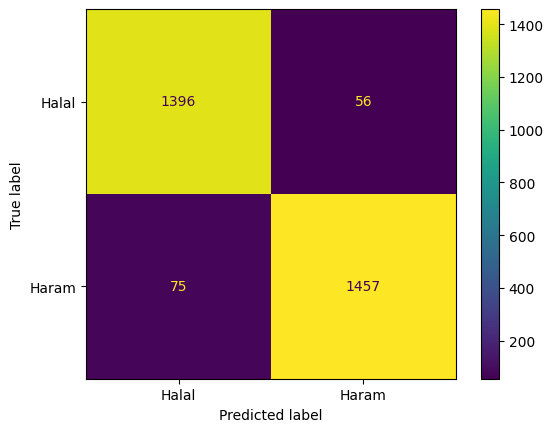

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Halal", "Haram"])
disp.plot()
plt.show()

# Test Data Results

In [61]:
y_test_pred = model_cnn.predict(X_test)
y_test_pred[y_test_pred <= 0.5] = 0. # halal
y_test_pred[y_test_pred > 0.5] = 1.  # haram
cm_test = confusion_matrix(y_test, y_test_pred)

24/24 [==============================] - 0s 8ms/step


In [62]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       377
           1       0.95      0.93      0.94       370

    accuracy                           0.94       747
   macro avg       0.94      0.94      0.94       747
weighted avg       0.94      0.94      0.94       747



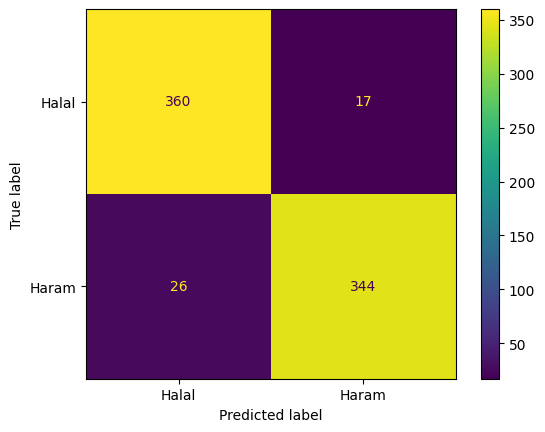

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Halal", "Haram"])
disp.plot()
plt.show()

### Sample Test

In [73]:
dir = '/content/drive/MyDrive/Database Raman/'
test_dataframes = defaultdict(dict)
process_directory(dir, test_dataframes, target_key=None)

In [74]:
test_dataframes['Babi'][0]

,0,1
0,1.000000,0.003195
1,0.999628,0.000000
2,0.999257,0.021655
3,0.998885,0.011546
4,0.998513,0.021655
...,...,...
2043,0.002495,0.758905
2044,0.001871,0.708149
2045,0.001248,0.656414
2046,0.000624,0.591080


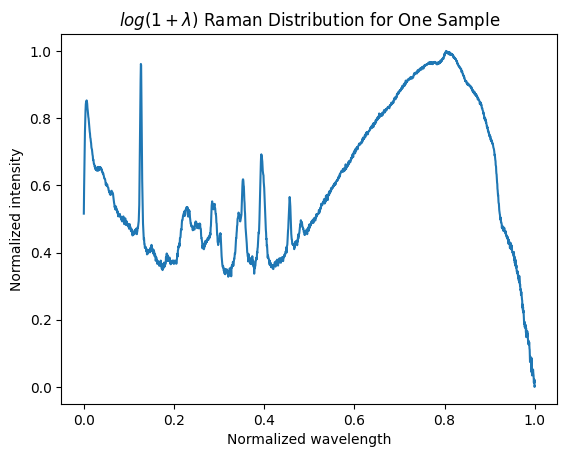

In [75]:
plt.plot(test_dataframes['Babi'][0][0], test_dataframes['Babi'][0][1])
plt.title(r"$log(1+\lambda)$ Raman Distribution for One Sample")
plt.xlabel("Normalized wavelength")
plt.ylabel("Normalized intensity")
plt.show()

In [80]:
len(test_dataframes['Babi'])

63

In [81]:
X_test_data = test_dataframes['Babi'][np.random.randint(0, len(test_dataframes['Babi']))].values
test_result = model_cnn.predict(np.expand_dims(X_test_data, axis=0))
if test_result <= 0.5:
  print("Halal")
else:
  print("Haram")

1/1 [==============================] - 0s 18ms/step
Haram


In [82]:
X_test_data = test_dataframes['Kambing'][np.random.randint(0, len(test_dataframes['Kambing']))].values
test_result = model_cnn.predict(np.expand_dims(X_test_data, axis=0))
if test_result <= 0.5:
  print("Halal")
else:
  print("Haram")

1/1 [==============================] - 0s 104ms/step
Halal
